In [1]:
# Transfer Learning

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Based on udacity's deep-learning-v2-pytorch with modification to use different model and dataset.
# Refer to Fastbook chapter 5 & 7: https://github.com/fastai/fastbook
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU.')
else:
    print('Training on GPU.')

Training on GPU.


In [3]:
# define training and test data directories
data_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
#test_dir = os.path.join(data_dir, 'val')

# classes are folders in each directory with these names
classes = ['NORMAL', 'PNEUMONIA']

In [4]:
# load and transform data using ImageFolder

# https://pytorch.org/docs/stable/torchvision/models.html
# resnet34 takes 224x224 images as input; thus we resize our images.
# per pytorch document, all pretrained models use the same normalization.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([transforms.Resize(460), # Fastbook chapter 5, Presizing. Increasing image size before cropping.
                                    transforms.RandomResizedCrop(224), # Cropping to meet Resnet34 input size.
                                    transforms.ToTensor(),
                                    normalize])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Training: %s images.' % len(train_data))
print('Test: %s images.' % len(test_data))

Training: 5216 images.
Test: 624 images.


In [5]:
# define dataloader parameters
batch_size = 64
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


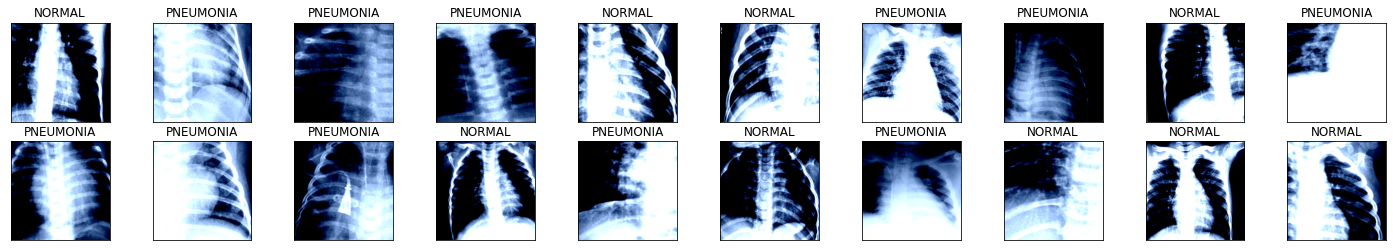

In [6]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy()

# plot the images in the batch with their corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2,0)))
    ax.set_title(classes[labels[idx]])

In [7]:
# load the pretrained model from pytorch
resnet34 = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [8]:
# print out the model structure
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
print('Input features = %s.' %resnet34.fc.in_features)
print('Output features = %s.' %resnet34.fc.out_features)

Input features = 512.
Output features = 1000.


In [10]:
# freeze training for all "features" layers because we use pretrained model.
for param in resnet34.fc.parameters():
    param.requires_grad = False

In [11]:
# final clasifier layer
import torch.nn as nn

n_inputs = resnet34.fc.in_features

# add last linear layer (n_inputs -> 2 chest xray classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes)) #n_inputs is the original resnet34 input. output is 2 now.

resnet34.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet34.cuda()
    
# check to see that the last layer produces the expected number of outputs. 2 is the expected output.
print('Input features = %s.' %resnet34.fc.in_features)
print('Output features = %s.' %resnet34.fc.out_features)

Input features = 512.
Output features = 2.


In [12]:
import torch.optim as optim

In [13]:
criterion = nn.CrossEntropyLoss()
# specify optimizer and learning rate
# optimizer = optim.SGD(resnet34.fc.parameters(), lr=0.001)
optimizer = optim.Adam(resnet34.fc.parameters(), lr=0.001) # 1e-3

In [14]:
# Training by looping through train_loader over resnet34 model.
print('Training start...')
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet34(data)
        # calculate the batch loss
        
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

print('Training completed.')

Training start...
Epoch 1, Batch 20 loss: 0.5161877200007439
Epoch 1, Batch 40 loss: 0.3868929892778397
Epoch 1, Batch 60 loss: 0.3406790681183338
Epoch 1, Batch 80 loss: 0.3042987123131752
Epoch 2, Batch 20 loss: 0.3002871595323086
Epoch 2, Batch 40 loss: 0.2918326705694199
Epoch 2, Batch 60 loss: 0.2752078875899315
Epoch 2, Batch 80 loss: 0.2749745741486549
Epoch 3, Batch 20 loss: 0.2714090250432492
Epoch 3, Batch 40 loss: 0.2542933739721775
Epoch 3, Batch 60 loss: 0.2709010928869248
Epoch 3, Batch 80 loss: 0.2567464850842953
Epoch 4, Batch 20 loss: 0.2490680962800980
Epoch 4, Batch 40 loss: 0.2760785348713398
Epoch 4, Batch 60 loss: 0.2769969306886196
Epoch 4, Batch 80 loss: 0.2759015634655952
Epoch 5, Batch 20 loss: 0.2447603501379490
Epoch 5, Batch 40 loss: 0.2619193516671657
Epoch 5, Batch 60 loss: 0.2775217831134796
Epoch 5, Batch 80 loss: 0.2324653871357441
Training completed.


In [15]:
# Testing
print('Testing start...')

# track test loss 
# over 2 chest xray classes
no_of_classes = len(classes)
test_loss = 0.0
class_correct = list(0. for i in range(no_of_classes))
class_total = list(0. for i in range(no_of_classes))

resnet34.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet34(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    #for i in range(batch_size):  <--this one doesn't work for the last batch so I changed it to the size of the target.data.
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(no_of_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('Testing completed.')

Testing start...
Test Loss: 0.561526

Test Accuracy of NORMAL: 35% (83/234)
Test Accuracy of PNEUMONIA: 98% (386/390)

Test Accuracy (Overall): 75% (469/624)
Testing completed.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


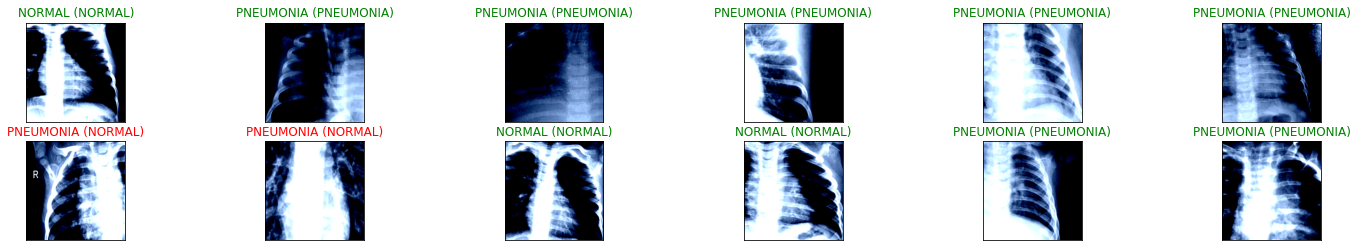

In [18]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = resnet34(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(12): # 12 images
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
#for idx in np.arange(batch_size):
    #ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))